In [1]:
import mpld3
mpld3.enable_notebook()
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df=pd.read_csv('v2_2.csv', sep=',',header=0)

df=df.drop(['Date','TickerName','open','high','low','volume'],axis=1)

data=df.to_numpy(dtype='int64')
data_scaled=min_max_scaler.fit_transform(data)
print(len(data_scaled))
print(data_scaled.shape[-1])


157208
24


In [2]:
#GENERATOR
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
#shift the min and max indexes to incorporate the delay and lookback.
    print("inside gen")
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            #this condition starts drawing batches from the start again and the remaining data points are left as it is.
            if i + batch_size >= max_index:
                i = min_index + lookback
            #max index is involved here because while drawing the last batch, it should consider only the batch size.
            rows = np.arange(i, min(i + batch_size, max_index))
            #here i remembers the end index of the previous batch, so that next time the batch begins from here.
            i += len(rows)
    #rows here are just indices referring to the slice and the samples in the bigger picture.
    #lookback//step gives the timesteps for each samples or rows mentioned above.
    #data.shape[-1] gives us the columnar data: total 24.
        samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            #print("inside loop")
        #indices here refers the indices or samples that serves as input to the particular jth sample.
        #in the next line, you can clearly see for the jth sample, you go back the lookback window, and take out
        #the sample that comes after step.
        #In a nutshell, all the 30 days ka data is not included from lookback window, the data is included after a period of step.
        #It makes sense because for N AND N+1th sample most of the lookback data will be same, but with steps we dont have that problem.
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            if(data[rows[j]+delay][23]-data[rows[j]][23]>=0):
                targets[j]=1
            else:
                #print("in else")
                targets[j]=0
            #the below comment is for prediction
            #targets[j] = data[rows[j] + delay][23]
        #print(samples)
        yield samples, targets

In [3]:
#Following the previous explanation, this makes total sense. FOr each sample, we will have 5 input rows and 1 output row.
#the shape of a sample will be (5,24)
lookback = 30
step = 6
delay = 7
batch_size = 128



train_gen = generator(data_scaled,lookback=lookback,delay=delay,min_index=0,max_index=100000,shuffle=True,step=step,batch_size=batch_size)

val_gen = generator(data_scaled,
lookback=lookback,
delay=delay,
min_index=100001,
max_index=125000,
step=step,
batch_size=batch_size)

test_gen = generator(data_scaled,
lookback=lookback,
delay=delay,
min_index=125001,
max_index=None,
step=step,
batch_size=batch_size)

val_steps = 194
#(125000 - 100001 - lookback)
test_steps =250
#(len(data_scaled) - 125001 - lookback)

In [4]:
i=0
while True:
    try:
        samples,targets=next(train_gen)
        print(samples.shape)
        print(targets)
        i=i+1
        break
    except StopIteration:
        break
    
#You see the code isnt raising any exception. Even WHile I was printing inside gen it happened only one time.
#In a way it has not left the function since I first called it. 
#It is still there but how is it drawing the batches infinitely?
#what happens after the yield statement. 
#If you look closely the yield is under infinite while loop.SO the control goes back there. 
#Question is how many batches of 128 would you draw?
#total is 100000, so you would draw 100000/128 batches=781.25. In effect, you should draw 780.
#But I still dont understand why the val_steps and test_steps variables are initialized such way. Fuck them.
#They should be 24999/128=195.3==194
#32208/128=251.6=250



inside gen
(128, 5, 24)
[0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 0. 1. 0. 0. 0. 1. 0.]


In [13]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


model = Sequential()
#model.add(layers.Embedding(24, 10))
model.add(layers.LSTM(30, return_sequences = True, input_shape = (lookback//step, data_scaled.shape[-1])))
model.add(layers.Dropout(0.4))
model.add(layers.LSTM(42))
model.add(layers.Dense(10))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['acc'])

model.summary()




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 30)             6600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 30)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 42)                12264     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                430       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 19,305
Trainable params: 19,305
Non-trainable params: 0
_________________________________________________________________


In [14]:
def infinite_sequence():
    num = 0
    while True:
        yield num
        num += 1
        
gen=infinite_sequence()
print(next(gen))
print(next(gen))

print(next(train_gen))

0
1
(array([[[1.86046512e-01, 1.85185185e-01, 2.60273973e-01, ...,
         3.13213341e-03, 2.81748631e-03, 5.81533349e-03],
        [1.97674419e-01, 1.72839506e-01, 2.46575342e-01, ...,
         3.32123641e-03, 2.95156040e-03, 5.69665322e-03],
        [2.20930233e-01, 1.97530864e-01, 2.05479452e-01, ...,
         3.77452928e-03, 3.46232513e-03, 6.05269404e-03],
        [2.32558140e-01, 2.09876543e-01, 1.91780822e-01, ...,
         3.37739659e-03, 3.52777237e-03, 5.93401377e-03],
        [2.90697674e-01, 2.46913580e-01, 2.19178082e-01, ...,
         3.77146600e-03, 3.77451487e-03, 6.17137432e-03]],

       [[9.30232558e-02, 1.60493827e-01, 2.19178082e-01, ...,
         1.23929834e-03, 1.09098908e-03, 2.21576074e-01],
        [1.51162791e-01, 1.23456790e-01, 2.05479452e-01, ...,
         1.21249462e-03, 1.13537132e-03, 2.14455258e-01],
        [1.62790698e-01, 1.23456790e-01, 1.64383562e-01, ...,
         1.69111427e-03, 1.46518146e-03, 2.30002374e-01],
        [1.39534884e-01, 1.481481

In [19]:
#steps per epoch might refer to the no of times the generator is called. // It is true.

history = model.fit(train_gen,
steps_per_epoch=780,
epochs=1000,
validation_data=val_gen,
validation_steps=val_steps)

Epoch 1/1000
780/780 [==============================] - 3s 4ms/step - loss: 0.6732 - acc: 0.5573 - val_loss: 0.6560 - val_acc: 0.5996
Epoch 2/1000
780/780 [==============================] - 3s 4ms/step - loss: 0.6738 - acc: 0.5568 - val_loss: 0.6559 - val_acc: 0.5996
Epoch 3/1000
780/780 [==============================] - 3s 4ms/step - loss: 0.6726 - acc: 0.5589 - val_loss: 0.6557 - val_acc: 0.5995
Epoch 4/1000
780/780 [==============================] - 3s 4ms/step - loss: 0.6728 - acc: 0.5570 - val_loss: 0.6582 - val_acc: 0.5996
Epoch 5/1000
780/780 [==============================] - 3s 4ms/step - loss: 0.6726 - acc: 0.5584 - val_loss: 0.6558 - val_acc: 0.5996
Epoch 6/1000
780/780 [==============================] - 3s 4ms/step - loss: 0.6710 - acc: 0.5622 - val_loss: 0.6556 - val_acc: 0.5996
Epoch 7/1000
780/780 [==============================] - 3s 4ms/step - loss: 0.6712 - acc: 0.5613 - val_loss: 0.6637 - val_acc: 0.5994
Epoch 8/1000
780/780 [==============================] - 3s 4ms

Epoch 62/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6658 - acc: 0.5684 - val_loss: 0.6561 - val_acc: 0.6012
Epoch 63/1000
780/780 [==============================] - 3s 4ms/step - loss: 0.6648 - acc: 0.5690 - val_loss: 0.6579 - val_acc: 0.6025
Epoch 64/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6644 - acc: 0.5691 - val_loss: 0.6582 - val_acc: 0.6010
Epoch 65/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6665 - acc: 0.5652 - val_loss: 0.6573 - val_acc: 0.6014
Epoch 66/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6654 - acc: 0.5668 - val_loss: 0.6573 - val_acc: 0.5973
Epoch 67/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6652 - acc: 0.5687 - val_loss: 0.6593 - val_acc: 0.6000
Epoch 68/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6651 - acc: 0.5672 - val_loss: 0.6594 - val_acc: 0.5998
Epoch 69/1000
780/780 [==============================] 

780/780 [==============================] - 3s 4ms/step - loss: 0.6529 - acc: 0.5906 - val_loss: 0.6763 - val_acc: 0.5889
Epoch 123/1000
780/780 [==============================] - 3s 4ms/step - loss: 0.6514 - acc: 0.5916 - val_loss: 0.6886 - val_acc: 0.5911
Epoch 124/1000
780/780 [==============================] - 3s 4ms/step - loss: 0.6512 - acc: 0.5919 - val_loss: 0.6772 - val_acc: 0.5879
Epoch 125/1000
780/780 [==============================] - 3s 4ms/step - loss: 0.6509 - acc: 0.5907 - val_loss: 0.6868 - val_acc: 0.5872
Epoch 126/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6503 - acc: 0.5923 - val_loss: 0.6865 - val_acc: 0.5822
Epoch 127/1000
780/780 [==============================] - 3s 4ms/step - loss: 0.6509 - acc: 0.5935 - val_loss: 0.6881 - val_acc: 0.5878
Epoch 128/1000
780/780 [==============================] - 3s 4ms/step - loss: 0.6504 - acc: 0.5903 - val_loss: 0.6865 - val_acc: 0.5942
Epoch 129/1000
780/780 [==============================] - 3s 4m

780/780 [==============================] - 3s 3ms/step - loss: 0.6348 - acc: 0.6136 - val_loss: 0.7216 - val_acc: 0.5818
Epoch 183/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6324 - acc: 0.6167 - val_loss: 0.7291 - val_acc: 0.5794
Epoch 184/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6349 - acc: 0.6130 - val_loss: 0.7194 - val_acc: 0.5821
Epoch 185/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6336 - acc: 0.6164 - val_loss: 0.7322 - val_acc: 0.5833
Epoch 186/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6338 - acc: 0.6150 - val_loss: 0.7244 - val_acc: 0.5805
Epoch 187/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6341 - acc: 0.6153 - val_loss: 0.7242 - val_acc: 0.5788
Epoch 188/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6341 - acc: 0.6166 - val_loss: 0.7184 - val_acc: 0.5816
Epoch 189/1000
780/780 [==============================] - 3s 3m

780/780 [==============================] - 3s 3ms/step - loss: 0.6214 - acc: 0.6318 - val_loss: 0.7448 - val_acc: 0.5746
Epoch 243/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6211 - acc: 0.6324 - val_loss: 0.7445 - val_acc: 0.5799
Epoch 244/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6221 - acc: 0.6329 - val_loss: 0.7417 - val_acc: 0.5815
Epoch 245/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6205 - acc: 0.6329 - val_loss: 0.7393 - val_acc: 0.5783
Epoch 246/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6200 - acc: 0.6331 - val_loss: 0.7468 - val_acc: 0.5742
Epoch 247/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6190 - acc: 0.6351 - val_loss: 0.7457 - val_acc: 0.5764
Epoch 248/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6180 - acc: 0.6353 - val_loss: 0.7591 - val_acc: 0.5721
Epoch 249/1000
780/780 [==============================] - 3s 3m

780/780 [==============================] - 3s 3ms/step - loss: 0.6093 - acc: 0.6457 - val_loss: 0.7729 - val_acc: 0.5718
Epoch 303/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6062 - acc: 0.6507 - val_loss: 0.7850 - val_acc: 0.5700
Epoch 304/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6089 - acc: 0.6463 - val_loss: 0.7783 - val_acc: 0.5690
Epoch 305/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6082 - acc: 0.6486 - val_loss: 0.7677 - val_acc: 0.5716
Epoch 306/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6089 - acc: 0.6456 - val_loss: 0.7734 - val_acc: 0.5681
Epoch 307/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6084 - acc: 0.6462 - val_loss: 0.7672 - val_acc: 0.5709
Epoch 308/1000
780/780 [==============================] - 3s 3ms/step - loss: 0.6083 - acc: 0.6483 - val_loss: 0.7762 - val_acc: 0.5712
Epoch 309/1000
780/780 [==============================] - 3s 3m

KeyboardInterrupt: 

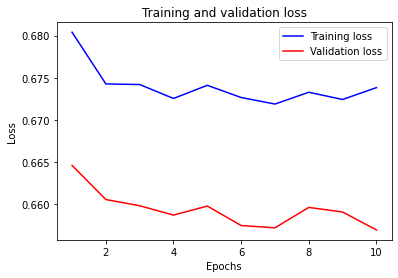

In [16]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, 11)

plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_scores = model.evaluate(test_gen,steps=test_steps, verbose=1)


In [17]:
preds=model.predict(test_gen,steps=250,verbose=1)

inside gen
250/250 [==============================] - 1s 2ms/step


In [18]:
print(preds)

#preds_unscaled=min_max_scaler.inverse_transform(preds)
actuals=[]
steps=test_steps
for i in range(steps):
    samples,targets=next(test_gen)
    actuals.extend(targets)
    

preds=preds.flatten()    
print(preds)
print(actuals)
print(len(preds))
print(len(actuals))
#print(preds_unscaled)

[[0.51957685]
 [0.51907676]
 [0.5183621 ]
 ...
 [0.55004567]
 [0.54980284]
 [0.5498373 ]]
[0.51957685 0.51907676 0.5183621  ... 0.55004567 0.54980284 0.5498373 ]
[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.

In [ ]:
print(len(actuals))
print(len(preds))

In [ ]:
ran=range(32000)
#preds=preds.tolist('float64')
#preds.append(0)
plt.plot(ran, actuals, 'b', label='True')
plt.plot(ran, preds, 'r', label='Preds')
#plt.title('Truth and Preds')
#plt.xlabel('steps')
#plt.ylabel('close')
#plt.legend()
plt.show()